# Transferability Analysis: Sparse GT vs GCN

This notebook fetches runs from wandb and creates transferability plots comparing Sparse GT and GCN performance across different training densities (resolutions).


In [46]:
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Initialize wandb API
api = wandb.Api()


## Fetch Runs from Wandb


In [47]:
ENTITY = 'alelab'
PROJECT = 'terrains'
TAG = 'e20TG_neurogf_terrain_graphs'

def fetch_runs(entity: str, project: str, tag: str) -> pd.DataFrame:
    """
    Fetch runs from a wandb project filtered by tag.
    
    Args:
        entity: wandb entity (user or team)
        project: wandb project name
        tag: wandb tag to filter runs
    
    Returns:
        DataFrame with run information
    """
    # Fetch running and finished runs with the specified tag
    filters = {
        "$and": [
            {"$or": [{"state": "running"}, {"state": "finished"}]},
            {"tags": tag}
        ]
    }
    runs = api.runs(f"{entity}/{project}", filters=filters)
    
    records = []
    for run in runs:
        # Get summary metrics
        summary = run.summary._json_dict
        config = run.config
        
        # Get normalized_abs_error (might be named normalized_abs_err in some runs)
        normalized_abs_error = summary.get('normalized_abs_error') or summary.get('normalized_abs_err', 0)
        
        # Skip runs with zero/missing normalized_abs_error
        if not normalized_abs_error or normalized_abs_error == 0:
            continue
        
        # Extract resolution from dataset_name or train_data
        dataset_name = config.get('dataset_name', '')
        train_data = config.get('train_data', '')
        
        # Try to extract resolution number (e.g., res17 -> 17)
        res_match = re.search(r'res(\d+)', dataset_name) or re.search(r'res(\d+)', train_data)
        if res_match:
            resolution = int(res_match.group(1))
        else:
            # Skip runs without resolution info
            continue
        
        records.append({
            'run_id': run.id,
            'run_name': run.name,
            'state': run.state,
            'resolution': resolution,
            'train_density': resolution,  # Higher res number = sparser graph
            'normalized_abs_error': normalized_abs_error,
            'layer_type': config.get('layer_type', 'Unknown'),
            'epochs': config.get('epochs', 0),
            'learning_rate': config.get('learning_rate', 0),
            'dataset_name': dataset_name,
        })
    
    return pd.DataFrame(records)


print(f"Fetching runs from {ENTITY}/{PROJECT} with tag '{TAG}'...")
runs_df = fetch_runs(ENTITY, PROJECT, TAG)
print(f"Found {len(runs_df)} valid runs")

Fetching runs from alelab/terrains with tag 'e20TG_neurogf_terrain_graphs'...
Found 62 valid runs


In [48]:
# reset colwidth
cw=pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', None)
display(df.groupby('layer_type')['resolution'].apply(lambda x: sorted(list(x.drop_duplicates()))).reset_index(name='resolutions'))
pd.set_option('display.max_colwidth', cw)

,layer_type,resolutions
0,MLP,[1]
1,SparseGT,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]"
2,TAGConv,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]"


In [49]:
# Combine dataframes
df = pd.concat([sparse_gt_df, gcn_df], ignore_index=True)

# Add density column (inverse of resolution squared - represents actual node density in 2D grid)
df['density'] = 1 / (df['resolution'] ** 2)

print(f"Total runs: {len(df)}")
print(f"\nRuns by model type:")
print(df['model_type'].value_counts())
print(f"\nDensities available (1/resolution²):")
print(sorted(df['density'].unique(), reverse=True))


Total runs: 64

Runs by model type:
model_type
GCN          37
Sparse GT    27
Name: count, dtype: int64

Densities available (1/resolution²):
[np.float64(1.0), np.float64(0.25), np.float64(0.1111111111111111), np.float64(0.0625), np.float64(0.04), np.float64(0.027777777777777776), np.float64(0.02040816326530612), np.float64(0.015625), np.float64(0.012345679012345678), np.float64(0.01), np.float64(0.008264462809917356), np.float64(0.006944444444444444), np.float64(0.005917159763313609), np.float64(0.00510204081632653), np.float64(0.0044444444444444444), np.float64(0.00390625), np.float64(0.0034602076124567475), np.float64(0.0030864197530864196), np.float64(0.002770083102493075), np.float64(0.0025)]


In [50]:
# Debug: Inspect the dataframe to verify both model types have data
print("DataFrame shape:", df.shape)
print("\nRuns per model_type:")
print(df['model_type'].value_counts())
print("\nLayer types in the data:")
print(df.groupby('model_type')['layer_type'].value_counts())
print("\nSample of each model type:")
print("\n--- Sparse GT samples ---")
print(df[df['model_type'] == 'Sparse GT'][['run_name', 'density', 'normalized_abs_error', 'layer_type']].head())
print("\n--- GCN samples ---")
print(df[df['model_type'] == 'GCN'][['run_name', 'density', 'normalized_abs_error', 'layer_type']].head())


DataFrame shape: (64, 13)

Runs per model_type:
model_type
GCN          37
Sparse GT    27
Name: count, dtype: int64

Layer types in the data:
model_type  layer_type
GCN         TAGConv       35
            MLP            2
Sparse GT   SparseGT      27
Name: count, dtype: int64

Sample of each model type:

--- Sparse GT samples ---
                              run_name   density  normalized_abs_error  \
0  terrain-graph-SparseGT-res19-stage1  0.002770              0.024907   
1  terrain-graph-SparseGT-res20-stage1  0.002500              0.015805   
2  terrain-graph-SparseGT-res18-stage1  0.003086              0.017924   
3  terrain-graph-SparseGT-res15-stage1  0.004444              0.016149   
4  terrain-graph-SparseGT-res13-stage1  0.005917              0.015455   

  layer_type  
0   SparseGT  
1   SparseGT  
2   SparseGT  
3   SparseGT  
4   SparseGT  

--- GCN samples ---
                        run_name  density  normalized_abs_error layer_type
27      terrain-graph-mlp-stage1  1

In [51]:
# Extract stage from dataset_name
# Rules:
# - If layer_type == 'SparseGT': 
#     - "norway/res##" = stage 1
#     - "res##_phase2" = stage 2
# - If layer_type != 'SparseGT':
#     - "norway/res##" = stage 1  
#     - "res##_phase{num}" = stage num

def extract_stage(row):
    layer_type = row['layer_type']
    dataset_name = row['dataset_name']
    
    if layer_type == 'SparseGT':
        # For SparseGT: norway/res## = stage 1, res##_phase2 = stage 2
        if 'norway/' in dataset_name:
            return 1
        elif '_phase2' in dataset_name:
            return 2
        else:
            return None
    else:
        # For other layer types (TAGConv, etc.): extract phase number
        if 'norway/' in dataset_name:
            return 1
        match = re.search(r'_phase(\d+)', dataset_name)
        if match:
            return int(match.group(1))
        else:
            return None

df['stage'] = df.apply(extract_stage, axis=1)

# Display the result
print("Stage distribution:")
print(df.groupby(['model_type', 'layer_type', 'stage']).size())
print("\nSample data with stage:")
df[['model_type', 'layer_type', 'dataset_name', 'stage', 'density', 'normalized_abs_error']].sample(25)

Stage distribution:
model_type  layer_type  stage
GCN         MLP         1.0       1
            TAGConv     1.0      17
                        2.0      18
Sparse GT   SparseGT    1.0      14
                        2.0      13
dtype: int64

Sample data with stage:


,model_type,layer_type,dataset_name,stage,density,normalized_abs_error
38,GCN,TAGConv,norway/res15,1.0,0.004444,0.016572
18,Sparse GT,SparseGT,norway/res10,1.0,0.010000,0.020938
43,GCN,TAGConv,res14_phase2,2.0,0.005102,0.007514
51,GCN,TAGConv,res10_phase2,2.0,0.010000,0.006166
53,GCN,TAGConv,norway/res08,1.0,0.015625,0.016618
6,Sparse GT,SparseGT,norway/res12,1.0,0.006944,0.014847
58,GCN,TAGConv,res06_phase2,2.0,0.027778,0.004327
40,GCN,TAGConv,res15_phase2,2.0,0.004444,0.007534
10,Sparse GT,SparseGT,res19_phase2,2.0,0.002770,0.007473
29,GCN,TAGConv,norway/res20,1.0,0.002500,0.018958


In [52]:
df[df.run_id=="58vwdzbe"]

,run_id,run_name,state,model_type,resolution,train_density,normalized_abs_error,layer_type,epochs,learning_rate,dataset_name,experiment_tag,density,stage
15,58vwdzbe,terrain-graph-SparseGT-res14_phase2-stage2,finished,Sparse GT,14,14,0.006456,SparseGT,1000,0.001,res14_phase2,e21_sparse_gt_terrain_phase2,0.005102,2.0


In [53]:
## Compute Accuracy Proxy from Normalized Absolute Error

# Since we have the mean relative error (normalized_abs_error = NMAE),
# we can compute an "accuracy proxy" as 1 - error (capped at 0-100%)
# This is NOT the same as threshold-based accuracy, but gives a comparable metric.

df['accuracy_proxy'] = (1 - df['normalized_abs_error'].clip(upper=1)) * 100

# Display the updated dataframe
print("Added accuracy_proxy column (100 * (1 - NMAE)):")
df[['model_type', 'density', 'normalized_abs_error', 'accuracy_proxy']].head(10)


Added accuracy_proxy column (100 * (1 - NMAE)):


,model_type,density,normalized_abs_error,accuracy_proxy
0,Sparse GT,0.002770,0.024907,97.509287
1,Sparse GT,0.002500,0.015805,98.419543
2,Sparse GT,0.003086,0.017924,98.207557
3,Sparse GT,0.004444,0.016149,98.385099
4,Sparse GT,0.005917,0.015455,98.454512
5,Sparse GT,0.003460,0.018019,98.198052
6,Sparse GT,0.006944,0.014847,98.515304
7,Sparse GT,0.005102,0.018058,98.194191
8,Sparse GT,0.003906,0.016074,98.392575
9,Sparse GT,0.002500,0.005520,99.448046


## Transferability Plot

A transferability plot shows how model performance changes with training data density. The x-axis represents density (1/resolution²), which corresponds to the actual node density ratio in the 2D grid. Higher values indicate denser training graphs. The y-axis shows the normalized absolute error.


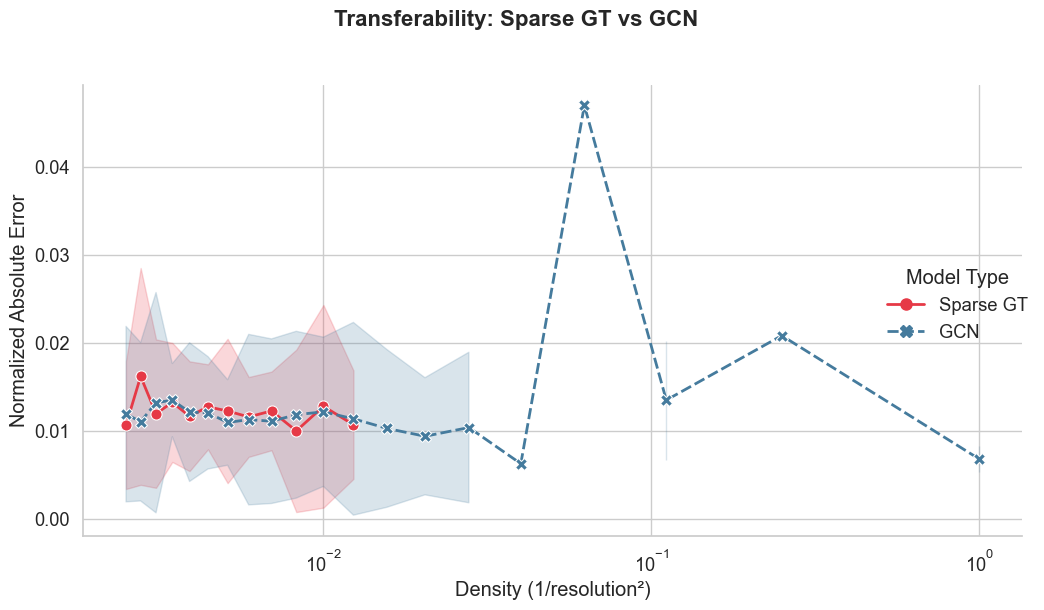

In [54]:
# Set plot style
sns.set_theme(style="whitegrid", font_scale=1.2)

# Create transferability plot
g = sns.relplot(
    data=df,
    x='density',
    y='normalized_abs_error',
    hue='model_type',
    kind='line',
    markers=True,
    style='model_type',
    height=6,
    aspect=1.5,
    errorbar='sd',  # Show standard deviation as error bands
    palette=['#E63946', '#457B9D'],  # Red for Sparse GT, Blue for GCN
    markersize=8,
    linewidth=2,
)

# Customize the plot
g.set_axis_labels("Density (1/resolution²)", "Normalized Absolute Error")
g.legend.set_title("Model Type")
g.fig.suptitle("Transferability: Sparse GT vs GCN", y=1.02, fontsize=16, fontweight='bold')

# Set x-axis to log scale
g.set(xscale='log')

plt.tight_layout()
plt.savefig('transferability_plot.png', dpi=150, bbox_inches='tight')
plt.show()


In [55]:
# # Summary statistics by model type and density
# summary_stats = df.groupby(['model_type', 'density'])['normalized_abs_error'].agg(
#     ['mean', 'std', 'count', 'min', 'max']
# ).round(4)

# print("Summary Statistics:")
# summary_stats


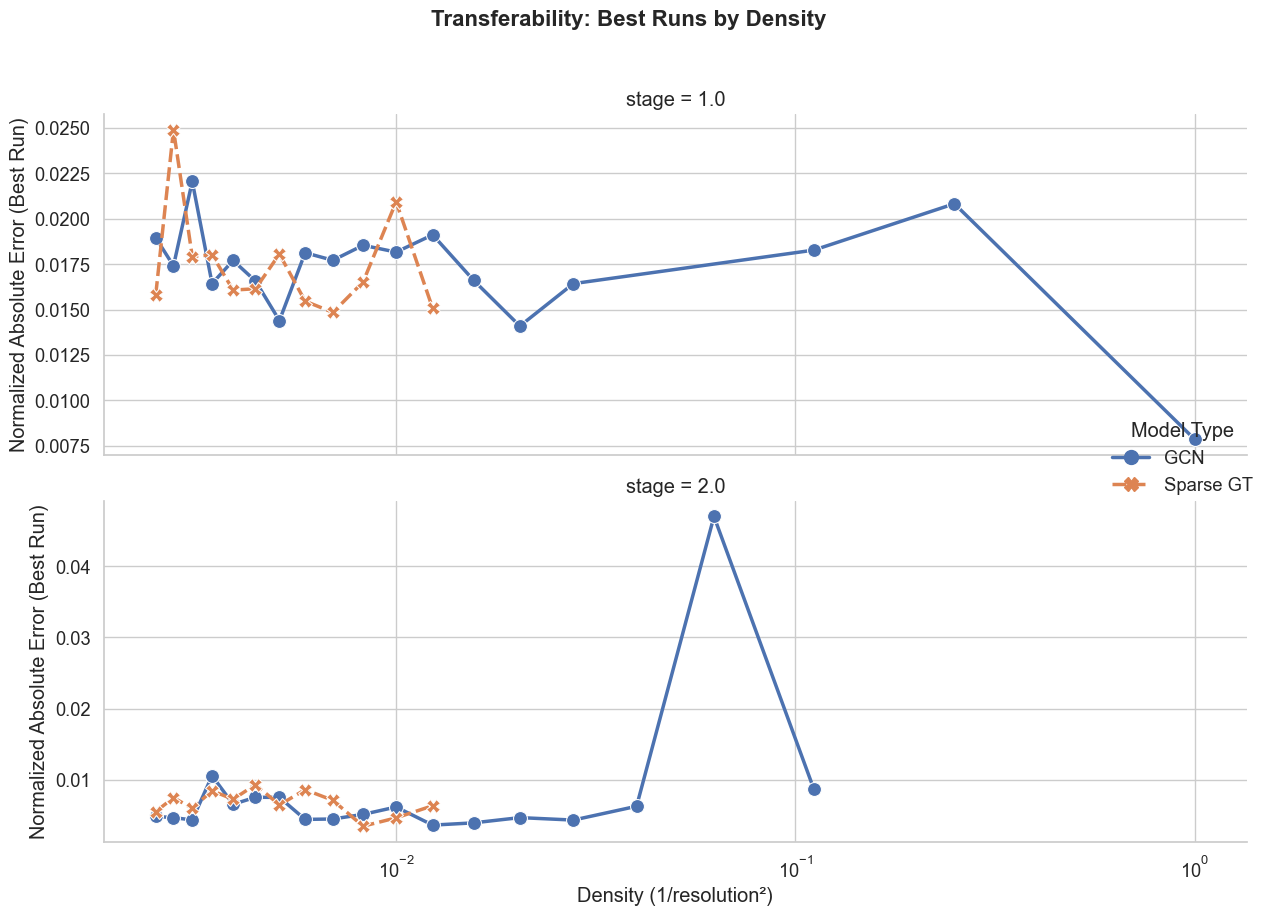

In [56]:
# Alternative view: Best performance per density per model
best_per_density = df.loc[df.groupby(['model_type', 'density', 'stage'])['normalized_abs_error'].idxmax()]

g2 = sns.relplot(
    data=best_per_density,
    x='density',
    y='normalized_abs_error',
    hue='model_type',
    kind='line',
    markers=True,
    style='model_type',
    row="stage",
    height=4.5,
    aspect=2.5,
    #palette=['#E63946', '#457B9D'],
    markersize=10,
    linewidth=2.5,
    facet_kws=dict(sharex=True, sharey=False),
)

g2.set_axis_labels("Density (1/resolution²)", "Normalized Absolute Error (Best Run)")
g2.legend.set_title("Model Type")
g2.fig.suptitle("Transferability: Best Runs by Density", y=1.02, fontsize=16, fontweight='bold')
g2.set(xscale='log')
plt.tight_layout()
plt.savefig('transferability_plot_best.png', dpi=150, bbox_inches='tight')
plt.show()


## Trimmed down, closer look at the small fractions

In [57]:
best_per_density.head()

,run_id,run_name,state,model_type,resolution,train_density,normalized_abs_error,layer_type,epochs,learning_rate,dataset_name,experiment_tag,density,stage,accuracy_proxy
29,cehkvmr9,terrain-graph-TAGConv-stage1,finished,GCN,20,20,0.018958,TAGConv,500,0.0001,norway/res20,e20TG_neurogf_terrain_graphs,0.002500,1.0,98.104237
31,j7q1o47n,terrain-graph-TAGConv-stage2,finished,GCN,20,20,0.004849,TAGConv,1000,0.0010,res20_phase2,e20TG_neurogf_terrain_graphs,0.002500,2.0,99.515111
30,fjmvtepv,terrain-graph-TAGConv-stage1,finished,GCN,19,19,0.017410,TAGConv,500,0.0001,norway/res19,e20TG_neurogf_terrain_graphs,0.002770,1.0,98.258980
32,rxju6dat,terrain-graph-TAGConv-stage2,finished,GCN,19,19,0.004669,TAGConv,1000,0.0010,res19_phase2,e20TG_neurogf_terrain_graphs,0.002770,2.0,99.533106
33,c64bcxcq,terrain-graph-TAGConv-stage1,finished,GCN,18,18,0.022063,TAGConv,500,0.0001,norway/res18,e20TG_neurogf_terrain_graphs,0.003086,1.0,97.793718


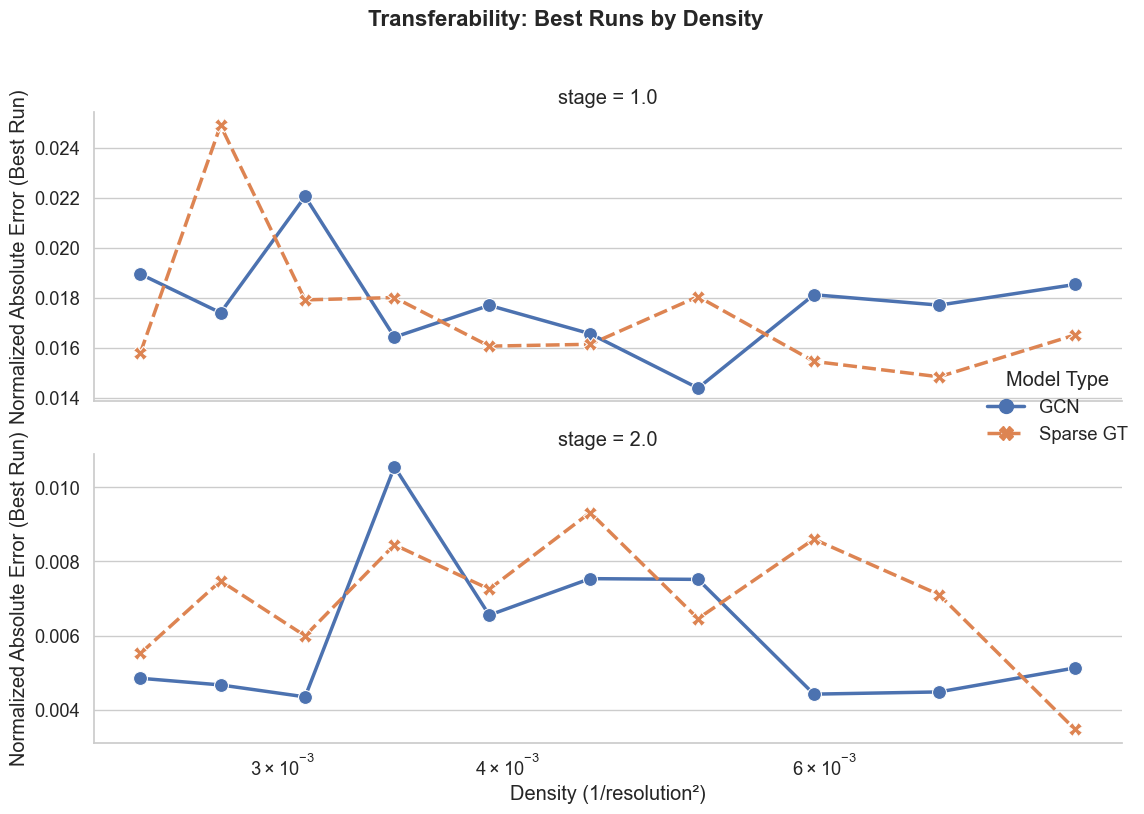

In [58]:
# Alternative view: Best performance per density per model
best_per_density = df.loc[df.groupby(['model_type', 'density', 'stage'])['normalized_abs_error'].idxmax()]

g2 = sns.relplot(
    data=best_per_density.query("train_density > 10"),
    x='density',
    y='normalized_abs_error',
    hue='model_type',
    kind='line',
    markers=True,
    style='model_type',
    row="stage",
    height=4,
    aspect=2.5,
    #palette=['#E63946', '#457B9D'],
    markersize=10,
    linewidth=2.5,
    facet_kws=dict(sharex=True, sharey=False),
)

g2.set_axis_labels("Density (1/resolution²)", "Normalized Absolute Error (Best Run)")
g2.legend.set_title("Model Type")
g2.fig.suptitle("Transferability: Best Runs by Density", y=1.02, fontsize=16, fontweight='bold')
g2.set(xscale='log')
plt.tight_layout()
plt.savefig('transferability_plot_best.png', dpi=150, bbox_inches='tight')
plt.show()


In [59]:
# # Export the combined dataframe for further analysis
# df.to_csv('wandb_runs_sparse_gt_gcn.csv', index=False)
# print("Data exported to wandb_runs_sparse_gt_gcn.csv")
